Helpful example

https://www.kaggle.com/tianxinl0106/content-based-anime-recommender

https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation

In [229]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
#from wordcloud import WordCloud, STOPWORDS
# Loading data
import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import collections
from sklearn.metrics import jaccard_similarity_score # Jaccard Similarity
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')

In [244]:
rating = pd.read_csv("rating.csv")
anime = pd.read_csv('anime.csv')
print (rating.shape, anime.shape)

(7813737, 3) (12294, 7)


In [245]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [246]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Data analysis for anime:

In [247]:
anime['genre'][:10]

0                 Drama, Romance, School, Supernatural
1    Action, Adventure, Drama, Fantasy, Magic, Mili...
2    Action, Comedy, Historical, Parody, Samurai, S...
3                                     Sci-Fi, Thriller
4    Action, Comedy, Historical, Parody, Samurai, S...
5               Comedy, Drama, School, Shounen, Sports
6              Action, Adventure, Shounen, Super Power
7                       Drama, Military, Sci-Fi, Space
8    Action, Comedy, Historical, Parody, Samurai, S...
9    Action, Comedy, Historical, Parody, Samurai, S...
Name: genre, dtype: object

In [248]:
# how many empty genres are there
anime['genre'].isnull().sum()

62

In [249]:
# filling 'empty' data
anime['genre'] = anime['genre'].fillna('None')
# split genre into a list
anime['genre'] = anime['genre'].apply(lambda x: x.split(', '))
anime["name"] = anime["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

In [250]:
# number of average episodes among anime shows
sum_ep = np.sum(int(x) if x != 'Unknown' else 0 for x in anime['episodes'])
ep_avg = int(sum_ep / len(anime['episodes']))
anime['episodes'] = anime['episodes'].apply(lambda x: ep_avg if x == 'Unknown' else int(x))
anime['rating'] = anime['rating'].fillna(ep_avg)

In [251]:
# flatten the list
genre_set = set(itertools.chain(*anime['genre'].values.tolist()))

genre_iter = itertools.chain(*anime['genre'].values.tolist())
genre_counter = collections.Counter(genre_iter)

In [252]:
genredf = pd.DataFrame.from_dict(genre_counter, orient='index').rename(columns={'index':'genre', 0:'count'})
genredf.sort_values('count', ascending=True, inplace=True)
genredf.head()

,count
Yaoi,39
Yuri,42
Josei,54
Shoujo Ai,55
None,62


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


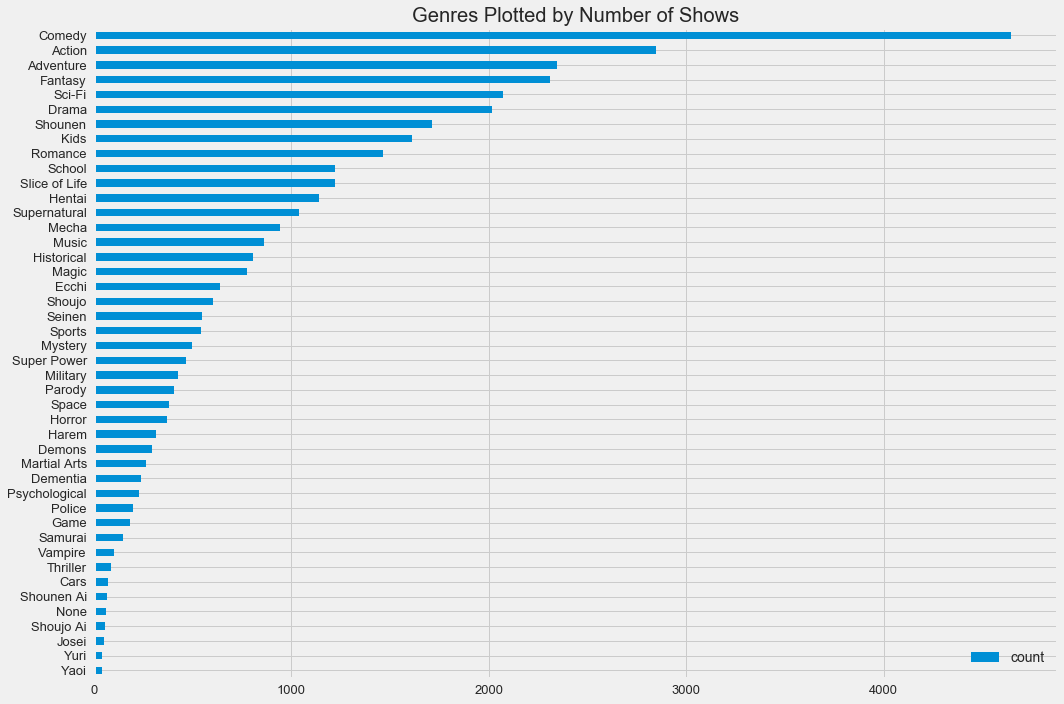

In [253]:
genredf.plot(kind='barh', figsize=(15, 10), title="Genres Plotted by Number of Shows")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [282]:
# change genre into one hot encoded
anime_extra = anime['genre'].str.join(sep='*').str.get_dummies(sep='*')
print(len(anime_extra))
anime_extra.head()

12294


,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


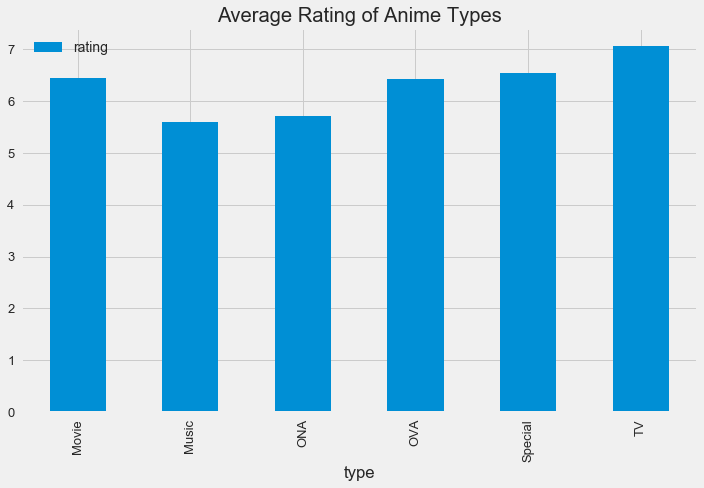

In [283]:
# average score of each type
anime.pivot_table(index='type', values=['rating'], aggfunc=np.mean).plot(
    kind='bar', figsize=(10, 7), title='Average Rating of Anime Types')
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [284]:
# shows with most episodes
anime.sort_values(by='episodes', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
6296,12393,Oyako Club,"[Comedy, Slice of Life]",TV,1818,6.18,160
929,2471,Doraemon 1979,"[Adventure, Comedy, Fantasy, Kids, Sci-Fi, Sho...",TV,1787,7.76,14233
9243,23349,Kirin Monoshiri Yakata,[Kids],TV,1565,5.56,116
5360,6277,Manga Nippon Mukashibanashi 1976,"[Fantasy, Historical]",TV,1471,6.48,406
6580,8213,Hoka Hoka Kazoku,[Comedy],TV,1428,6.05,194


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


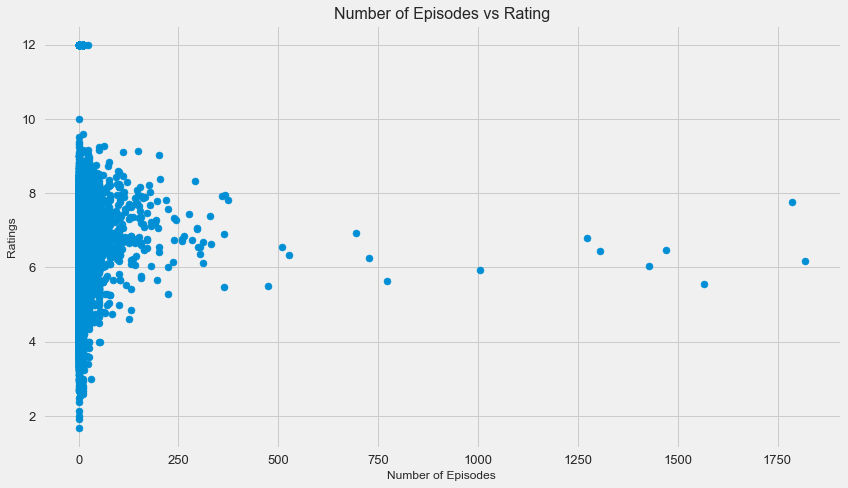

In [285]:
plt.figure(figsize=(12, 7))
plt.title('Number of Episodes vs Rating', fontsize=16)
plt.scatter(anime['episodes'], anime['rating'])
plt.xlabel('Number of Episodes', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [286]:
anime.iloc[anime['rating'].argmax()]

anime_id                       34502
name                 Inazma Delivery
genre       [Action, Comedy, Sci-Fi]
type                              TV
episodes                          10
rating                            12
members                           32
Name: 8968, dtype: object

/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


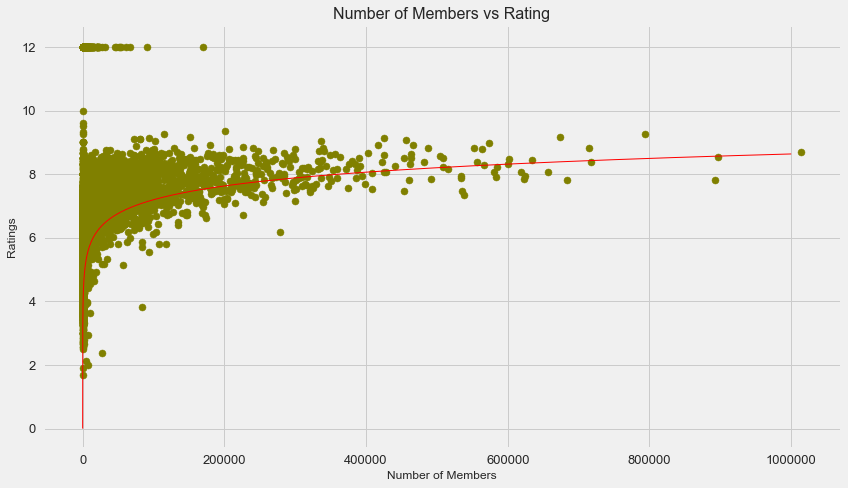

In [341]:
plt.figure(figsize=(12, 7))
plt.title('Number of Members vs Rating', fontsize=16)
plt.plot(np.arange(0, 1000000), 1/1.6*np.log(np.arange(0,1000000)), color='red', linewidth=1)
plt.scatter(anime['members'], anime['rating'], color='olive')
plt.xlabel('Number of Members', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [288]:
anime['rating'].isnull().sum()

0

/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


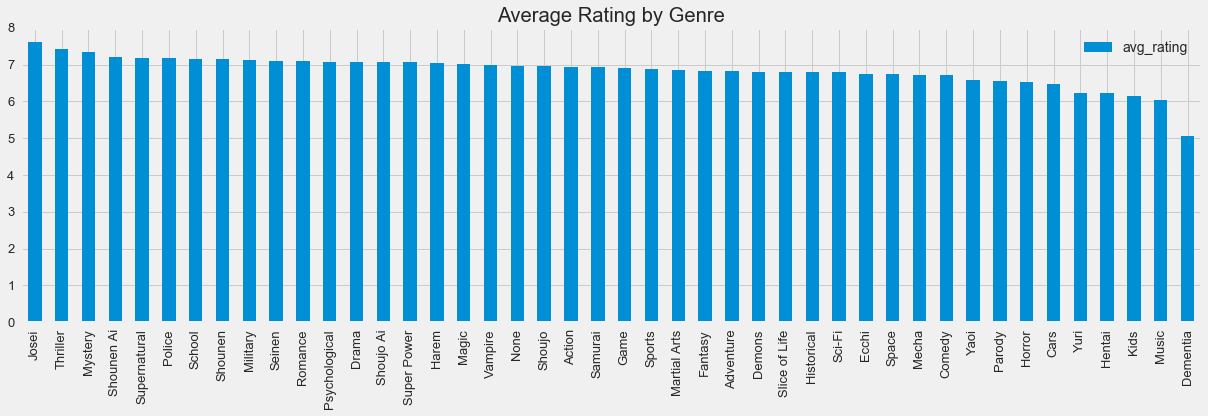

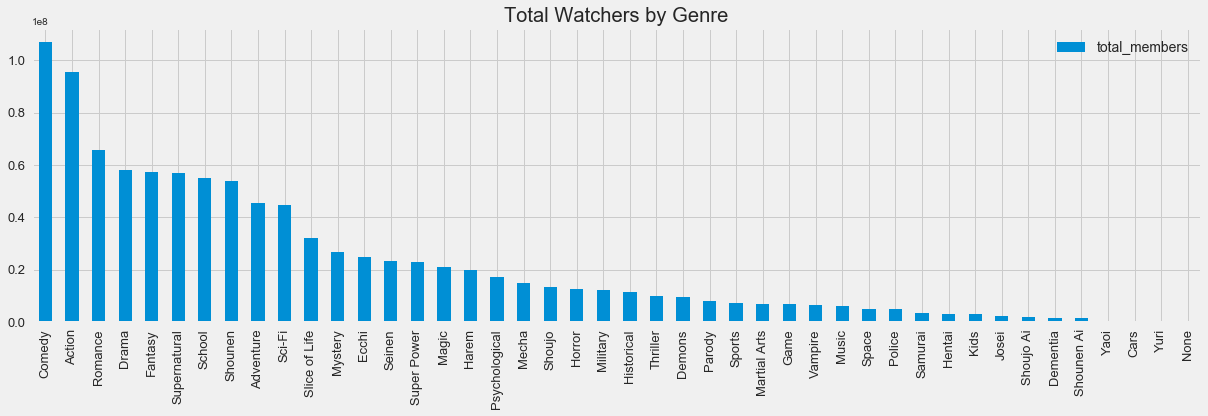

In [343]:
# average score of each genre
avg_genre_dict = {}
total_genre_watcher = {}
for genre in genre_set:
    sum_rating = 0
    total_watchers = 0
    for i, x in enumerate(anime_extra[genre]):
        if x == 1:
            sum_rating += anime['rating'][i]
            total_watchers += anime['members'][i]
    avg_genre_dict[genre] = sum_rating / anime_extra[genre].sum()
    total_genre_watcher[genre] = total_watchers
pd.DataFrame\
    .from_dict(avg_genre_dict, orient='index')\
    .rename(columns={0: 'avg_rating'}).sort_values(by='avg_rating', ascending=False)\
    .plot(kind='bar', figsize=(17, 6), title="Average Rating by Genre")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

pd.DataFrame\
    .from_dict(total_genre_watcher, orient='index')\
    .rename(columns={0: 'total_members'}).sort_values(by='total_members', ascending=False)\
    .plot(kind='bar', figsize=(17, 6), title="Total Watchers by Genre")
plt.legend(fontsize=14)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);

In [331]:
def pca_anime(data, title, color):
    anime_full = pd.concat(data, axis=1)

    # dimensionality using PCA
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(anime_full)

    print(pca_data)

    plt.figure(figsize=(13, 7))
    plt.title(title, fontsize=16)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], color=color)
    plt.xticks(fontsize=13);
    plt.yticks(fontsize=13);

[[  1.82558660e+05  -1.99703716e+01]
 [  7.75593663e+05   1.50976299e+01]
 [  9.61906629e+04   3.41035068e+01]
 ..., 
 [ -1.78523393e+04  -7.53549222e+00]
 [ -1.78963394e+04  -1.05332655e+01]
 [ -1.79293394e+04  -1.05308897e+01]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


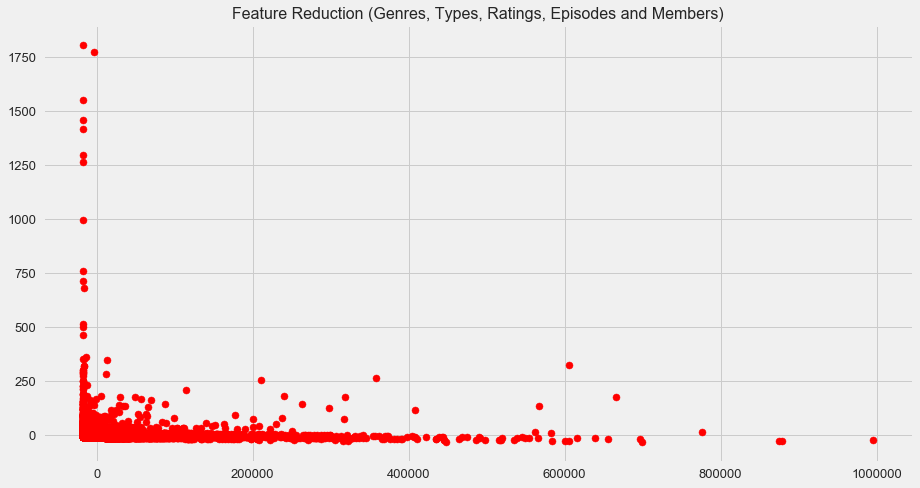

In [335]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes', 'rating', 'members']]
], "Feature Reduction (Genres, Types, Ratings, Episodes and Members)", 'red')

[[-11.36904428   2.83249005]
 [ 51.63557634   2.79946171]
 [ 38.63622088   2.73983772]
 ..., 
 [ -8.37741582  -1.79404446]
 [-11.37721299  -1.68931043]
 [-11.37613797  -1.20173971]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


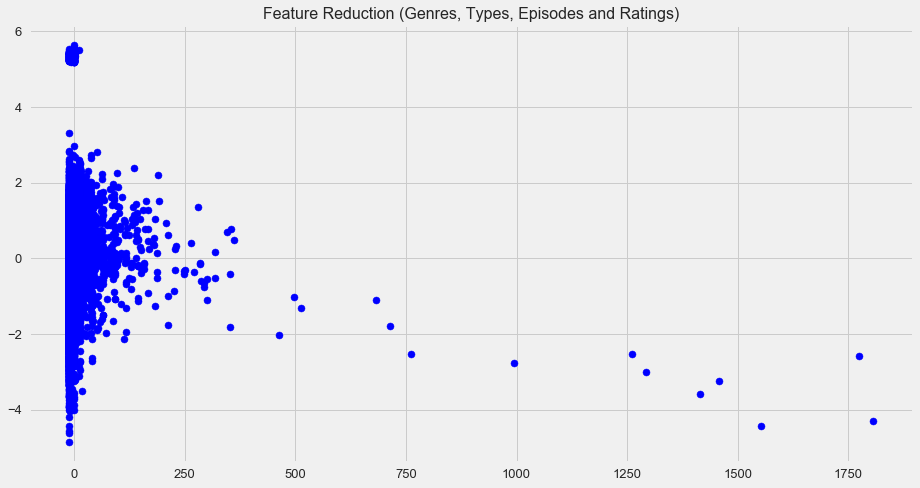

In [337]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes', 'rating']]
], "Feature Reduction (Genres, Types, Episodes and Ratings)", 'blue')

[[-11.37397234   0.08154643]
 [ 51.63093888  -0.70135446]
 [ 38.631581    -0.97271661]
 ..., 
 [ -8.3744443    1.15097159]
 [-11.37442194   1.14224167]
 [-11.37419091   0.57760471]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


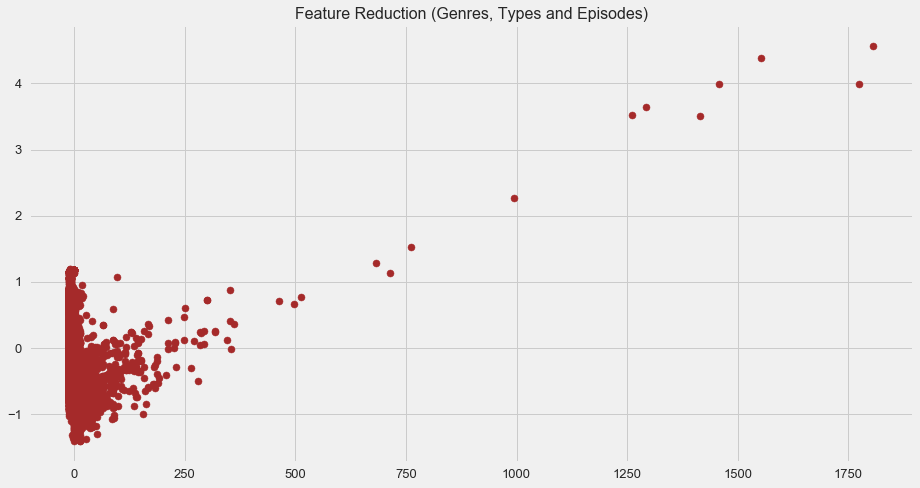

In [338]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
    anime[['episodes']]
], "Feature Reduction (Genres, Types and Episodes)", 'brown')

[[-0.17102215 -0.02381352]
 [ 0.86575691  1.26056129]
 [ 1.10183949  0.43908444]
 ..., 
 [-1.12782185 -0.22474511]
 [-1.12782185 -0.22474511]
 [-0.6410567   0.0388079 ]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


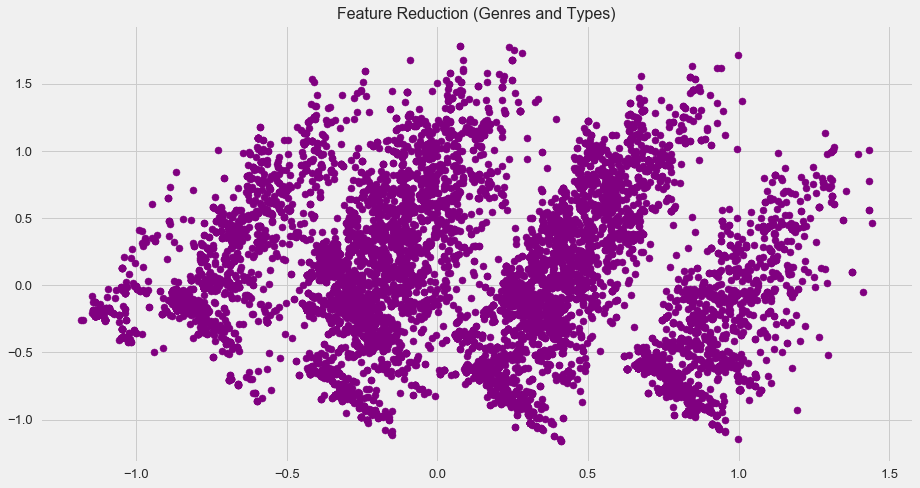

In [339]:
pca_anime([
    anime_extra,
    pd.get_dummies(anime[['type']]),
], "Feature Reduction (Genres and Types)", 'purple')

[[-0.22693371 -0.39178539]
 [ 1.26773783  0.50302626]
 [ 0.53059133  0.97762904]
 ..., 
 [-0.15103732 -0.705279  ]
 [-0.15103732 -0.705279  ]
 [-0.15103732 -0.705279  ]]


/Users/tuvttran/anaconda3/envs/ML/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


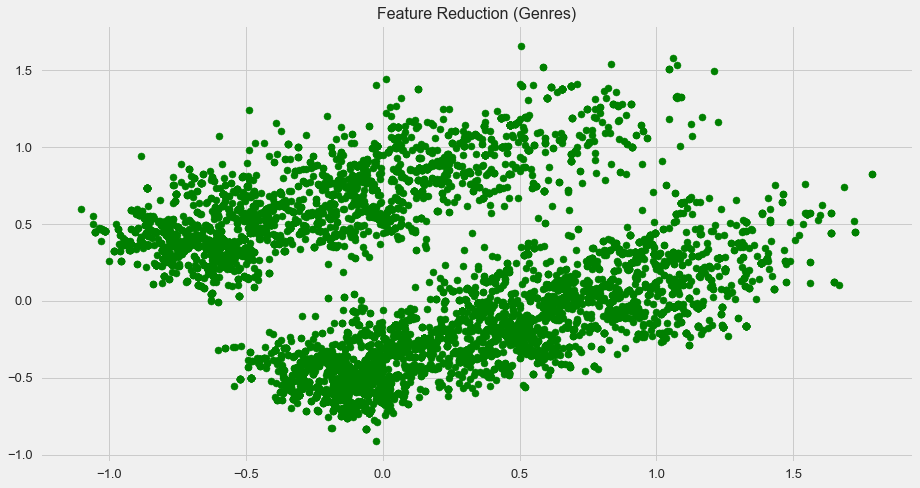

In [340]:
pca_anime([
    anime_extra,
], "Feature Reduction (Genres)", 'green')

### Data analysis for user:

In [228]:
# merge anime and user data on anime_id
anime_user = pd.merge(anime, rating, on=['anime_id', 'anime_id'])\
            .rename(columns={'rating_x': 'avg_rating', 'rating_y': 'indi_rating'})
anime_user.head(10)

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,indi_rating
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,278,-1
5,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,322,10
6,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,398,10
7,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,462,8
8,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,490,10
9,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630,548,10
